In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
import flexynesis
import torch
torch.set_num_threads(4)

Seed set to 42


In [2]:
# parameters cell (required to pass arguments to the notebook) (see View -> show right sidebar -> add tag -> parameters)
HPO_ITER = 5 # number of HPO iterations for final modeling run

In [3]:
if not os.path.exists("brca_metabric_processed"):
    !wget -O brca_metabric.tgz "https://bimsbstatic.mdc-berlin.de/akalin/buyar/flexynesis-benchmark-datasets/brca_metabric_processed.tgz" && tar -xzvf brca_metabric.tgz

--2025-03-11 14:55:18--  https://bimsbstatic.mdc-berlin.de/akalin/buyar/flexynesis-benchmark-datasets/brca_metabric_processed.tgz
Resolving bimsbstatic.mdc-berlin.de (bimsbstatic.mdc-berlin.de)... 141.80.181.47, 141.80.181.46
connected. to bimsbstatic.mdc-berlin.de (bimsbstatic.mdc-berlin.de)|141.80.181.47|:443... 
HTTP request sent, awaiting response... 200 OK
Length: 407225158 (388M) [application/octet-stream]
Saving to: ‘brca_metabric.tgz’

brca_metabric.tgz   100%[===================>] 388.36M   191MB/s    in 2.0s    

2025-03-11 14:55:21 (191 MB/s) - ‘brca_metabric.tgz’ saved [407225158/407225158]

brca_metabric_processed/
brca_metabric_processed/test/
brca_metabric_processed/test/gex.csv
brca_metabric_processed/test/mut.csv
brca_metabric_processed/test/clin.csv
brca_metabric_processed/test/cna.csv
brca_metabric_processed/9606.protein.aliases.v12.0.txt.gz
brca_metabric_processed/9606.protein.links.v12.0.txt.gz
brca_metabric_processed/train/
brca_metabric_processed/train/gex.csv
br

In [4]:
# train data
!wc -l ./brca_metabric_processed/train/*

     1307 ./brca_metabric_processed/train/clin.csv
    22543 ./brca_metabric_processed/train/cna.csv
    20604 ./brca_metabric_processed/train/gex.csv
      174 ./brca_metabric_processed/train/mut.csv
    44628 total


In [5]:
# test data
!wc -l ./brca_metabric_processed/test/* 

      561 ./brca_metabric_processed/test/clin.csv
    22543 ./brca_metabric_processed/test/cna.csv
    20604 ./brca_metabric_processed/test/gex.csv
      174 ./brca_metabric_processed/test/mut.csv
    43882 total


In [6]:
data_importer = flexynesis.DataImporter(path ='./brca_metabric_processed/', 
                                        data_types = ['gex', 'cna'], 
                                        concatenate=False, 
                                        top_percentile=10, 
                                        min_features=100, 
                                        variance_threshold=0.8, # set to 0.8 for 80%   
                                       )
train_dataset, test_dataset = data_importer.import_data()


[INFO] ================= Importing Data =================
[INFO] Validating data folders...

[INFO] ----------------- Reading Data ----------------- 
[INFO] Importing ./brca_metabric_processed/train/cna.csv...
[INFO] Importing ./brca_metabric_processed/train/clin.csv...
[INFO] Importing ./brca_metabric_processed/train/gex.csv...

[INFO] ----------------- Reading Data ----------------- 
[INFO] Importing ./brca_metabric_processed/test/cna.csv...
[INFO] Importing ./brca_metabric_processed/test/clin.csv...
[INFO] Importing ./brca_metabric_processed/test/gex.csv...

[INFO] ----------------- Checking for problems with the input data ----------------- 
[INFO] Data structure is valid with no errors or warnings.

[INFO] ----------------- Processing Data (train) ----------------- 

[INFO] ----------------- Cleaning Up Data ----------------- 

[INFO] working on layer:  gex
[INFO] Imputing NA values to median of features, affected # of cells in the matrix 7  # of rows: 5
[INFO] Number of NA value

Filtering redundant features: 100%|██████████| 412/412 [00:00<00:00, 8551.67it/s]


[INFO] Implementing feature selection using laplacian score for layer: cna with  4509 features  and  1303  samples 


Filtering redundant features: 100%|██████████| 450/450 [00:00<00:00, 325251.90it/s]



[INFO] ----------------- Processing Data (test) ----------------- 

[INFO] ----------------- Cleaning Up Data ----------------- 

[INFO] working on layer:  gex
[INFO] Number of NA values:  0
[INFO] DataFrame gex - Removed 16482 features.

[INFO] working on layer:  cna
[INFO] Imputing NA values to median of features, affected # of cells in the matrix 63  # of rows: 51
[INFO] Number of NA values:  0
[INFO] DataFrame cna - Removed 18033 features.
[INFO] DataFrame gex - Removed 2 samples (0.36%).
[INFO] DataFrame cna - Removed 2 samples (0.36%).

[INFO] ----------------- Harmonizing Data Sets ----------------- 

[INFO] ----------------- Finished Harmonizing ----------------- 

[INFO] ----------------- Normalizing Data ----------------- 

[INFO] ----------------- Normalizing Data ----------------- 
[INFO] Training Data Stats:  {'feature_count in: cna': 450, 'feature_count in: gex': 408, 'sample_count': 1303}
[INFO] Test Data Stats:  {'feature_count in: cna': 450, 'feature_count in: gex': 4

In [7]:
train_dataset.dat

{'cna': tensor([[-1.0024, -1.0362, -1.0212,  ..., -1.0112, -1.0365, -1.0374],
         [-1.0024, -1.0362, -1.0212,  ..., -1.0112, -1.0365, -1.0374],
         [-1.0024, -1.0362, -1.0212,  ..., -1.0112, -1.0365, -1.0374],
         ...,
         [ 0.2908, -2.3234, -2.3007,  ..., -2.2954, -2.3202, -2.3285],
         [ 0.2908,  0.2509,  0.2583,  ...,  0.2730,  0.2473,  0.2537],
         [ 0.2908,  0.2509,  0.2583,  ...,  0.2730,  0.2473,  0.2537]]),
 'gex': tensor([[ 0.2246,  0.0949,  0.6605,  ...,  0.3199, -0.5804, -0.2763],
         [ 0.4494,  0.2856,  0.7417,  ..., -1.6710, -1.8903, -1.9921],
         [-0.6150, -0.7559, -1.6350,  ..., -0.1519, -0.1190, -0.0591],
         ...,
         [-0.2768, -0.9645, -1.5302,  ..., -0.5674, -0.6198, -0.5264],
         [ 0.6311,  1.0591,  1.1127,  ...,  0.3443,  0.2635, -0.0371],
         [ 0.3326,  0.4111,  0.2754,  ..., -0.3708, -0.3251, -0.2657]])}

In [8]:
train_dataset.dat['gex'].shape, train_dataset.dat['cna'].shape

(torch.Size([1303, 408]), torch.Size([1303, 450]))

In [9]:
#dataset.ann contains the sample annotation data (from clin.csv), where the keys are variable names and values are tensors.
train_dataset.ann

{'LYMPH_NODES_EXAMINED_POSITIVE': tensor([1, 1, 4,  ..., 3, 0, 1]),
 'NPI': tensor([4.0420, 4.0340, 6.0360,  ..., 5.0500, 3.0800, 3.0520],
        dtype=torch.float64),
 'AGE_AT_DIAGNOSIS': tensor([58.7500, 61.2800, 56.2700,  ..., 59.2900, 71.6700, 61.7200],
        dtype=torch.float64),
 'OS_MONTHS': tensor([143.6000, 181.4667,  19.7333,  ..., 226.7333,  43.9000,  88.5000],
        dtype=torch.float64),
 'RFS_MONTHS': tensor([ 88.1900, 179.0800,  10.1300,  ..., 223.7500,  24.0500,  87.3400],
        dtype=torch.float64),
 'CELLULARITY': tensor([0., 2., 2.,  ..., 0., 2., 2.], dtype=torch.float64),
 'CHEMOTHERAPY': tensor([1., 0., 1.,  ..., 1., 0., 0.], dtype=torch.float64),
 'COHORT': tensor([3., 0., 2.,  ..., 1., 2., 3.], dtype=torch.float64),
 'ER_IHC': tensor([1., 1., 0.,  ..., 0., nan, 1.], dtype=torch.float64),
 'HER2_SNP6': tensor([1., 2., 2.,  ..., 2., 2., 2.], dtype=torch.float64),
 'HORMONE_THERAPY': tensor([1., 1., 1.,  ..., 0., 0., 1.], dtype=torch.float64),
 'INFERRED_MENOP

In [10]:
#A mapping of the sample labels for categorical variables can be found in dataset.label_mappings
train_dataset.label_mappings

{'CELLULARITY': {0: 'High', 1: 'Low', 2: 'Moderate', 3: nan},
 'CHEMOTHERAPY': {0: 'NO', 1: 'YES'},
 'COHORT': {0: 'cohort1',
  1: 'cohort2',
  2: 'cohort3',
  3: 'cohort4',
  4: 'cohort5'},
 'ER_IHC': {0: 'Negative', 1: 'Positve', 2: nan},
 'HER2_SNP6': {0: 'GAIN', 1: 'LOSS', 2: 'NEUTRAL', 3: 'UNDEF'},
 'HORMONE_THERAPY': {0: 'NO', 1: 'YES'},
 'INFERRED_MENOPAUSAL_STATE': {0: 'Post', 1: 'Pre'},
 'SEX': {0: 'Female'},
 'INTCLUST': {0: '1',
  1: '10',
  2: '2',
  3: '3',
  4: '4ER+',
  5: '4ER-',
  6: '5',
  7: '6',
  8: '7',
  9: '8',
  10: '9'},
 'OS_STATUS': {0: '0:LIVING', 1: '1:DECEASED'},
 'CLAUDIN_SUBTYPE': {0: 'Basal',
  1: 'Her2',
  2: 'LumA',
  3: 'LumB',
  4: 'NC',
  5: 'Normal',
  6: 'claudin-low'},
 'THREEGENE': {0: 'ER+/HER2- High Prolif',
  1: 'ER+/HER2- Low Prolif',
  2: 'ER-/HER2-',
  3: 'HER2+',
  4: nan},
 'VITAL_STATUS': {0: 'Died of Disease',
  1: 'Died of Other Causes',
  2: 'Living',
  3: nan},
 'LATERALITY': {0: 'Left', 1: 'Right', 2: nan},
 'RADIO_THERAPY': {0: 

In [11]:
#As the data matrices are stored as tensors, the row and column names cannot be stored as tensors. These are stored in the same dataset object as:dataset.samples and dataset.features
train_dataset.samples[1:10], train_dataset.features

(['MB-0568',
  'MB-4733',
  'MB-7154',
  'MB-5559',
  'MB-0394',
  'MB-6100',
  'MB-0221',
  'MB-5341',
  'MB-6328'],
 {'cna': Index(['MSTO2P', 'FCRLA', 'TOP1P1', 'LAMC1', 'TDRKH', 'MSTO1', 'DAP3',
         'YY1AP1', 'SLC50A1', 'EFNA1',
         ...
         'SELENBP1', 'XPR1', 'SOAT1', 'PI4KB', 'RFX5', 'SELP', 'AXDND1',
         'KIAA1614', 'TRMT1L', 'FMO9P'],
        dtype='object', length=450),
  'gex': Index(['FOXA1', 'MLPH', 'ESR1', 'GATA3', 'SPDEF', 'TBC1D9', 'FOXC1', 'C1S',
         'XBP1', 'CA12',
         ...
         'N4BP2', 'TNFSF14', 'LEP', 'INIP', 'RPL7L1', 'MBD4', 'HCG2P7', 'ZNF430',
         'KIAA1791', 'IL10'],
        dtype='object', length=408)})

In [12]:
#We can get a summary of sample metadata using print_summary_stats. For categorical variables, we can the sample counts per label and for numerical variables, we get mean/median statistics.
flexynesis.print_summary_stats(train_dataset)

Summary for variable: LYMPH_NODES_EXAMINED_POSITIVE
Numerical Variable Summary: Median = 0.0, Mean = 1.9286262471220261
------
Summary for variable: NPI
Numerical Variable Summary: Median = 4.04, Mean = 4.017291158864159
------
Summary for variable: AGE_AT_DIAGNOSIS
Numerical Variable Summary: Median = 61.79, Mean = 61.30643898695319
------
Summary for variable: OS_MONTHS
Numerical Variable Summary: Median = 114.4666667, Mean = 125.03573804066693
------
Summary for variable: RFS_MONTHS
Numerical Variable Summary: Median = 100.63, Mean = 109.94034535686876
------
Summary for variable: CELLULARITY
Categorical Variable Summary:
  Label: High, Count: 656
  Label: Low, Count: 136
  Label: Moderate, Count: 484
  Label: nan, Count: 27
------
Summary for variable: CHEMOTHERAPY
Categorical Variable Summary:
  Label: NO, Count: 1044
  Label: YES, Count: 259
------
Summary for variable: COHORT
Categorical Variable Summary:
  Label: cohort1, Count: 308
  Label: cohort2, Count: 196
  Label: cohort3

Training flexynesis models

We create a tuner object by specifying:

dataset: the training dataset (as we constructed above) model_class: which model architecture to use: a) DirectPred: a fully connected network (standard multilayer perceptron) with supervisor heads (one MLP for each target variable) b) Supervised Variational Autoencoder: A variational autoencoder (MMD-loss) with supervisor heads (one MLP for each target variable) c) MultiTripletNetwork: A network structured in triplets to enable contrastive learning (using triplet loss) and additiona supervisor heads (one MLP for each target variable) target_variables: A comma separated list of target variables (specify the column headers from the clin.csv). One MLP per each target variable will be created. The target variables may contain NA values config_name: which hyperparameter search space configuration to use. n_iter: How many hyperparameter search steps to implement. This example runs 1 hyperparameter search step using DirectPred architecture and a hyperparameter configuration space defined for "DirectPred" with a supervisor head for "CLAUDIN_SUBTYPE" variable: We use perform_tuning function to run the hyperparameter optimisation procedure. At the end of the parameter optimisation, best model will be selected and returned.

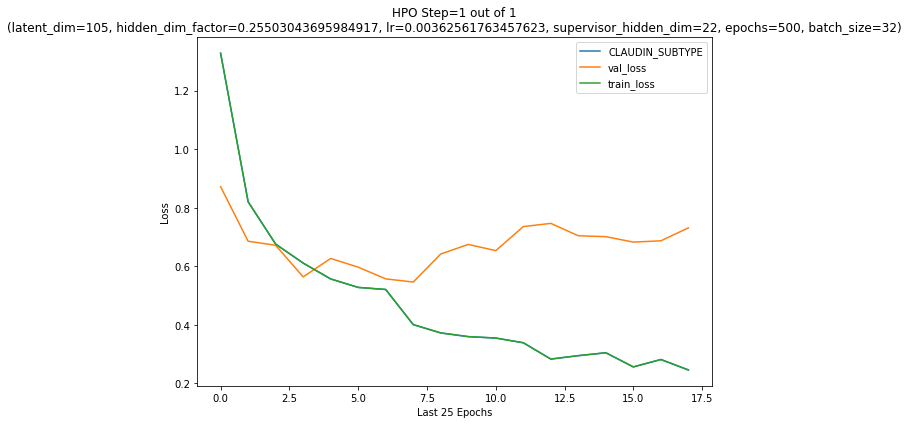

Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      CLAUDIN_SUBTYPE      │    0.7313112616539001     │
│         val_loss          │    0.7313112616539001     │
└───────────────────────────┴───────────────────────────┘

Tuning Progress: 100%|██████████| 1/1 [00:16<00:00, 16.78s/it, Iteration=1, Best Loss=0.731]

[INFO] current best val loss: 0.7313112616539001; best params: {'latent_dim': 105, 'hidden_dim_factor': 0.25503043695984917, 'lr': 0.00362561763457623, 'supervisor_hidden_dim': 22, 'epochs': 500, 'batch_size': 32} since 0 hpo iterations


In [13]:
tuner = flexynesis.HyperparameterTuning(dataset = train_dataset, 
                                        model_class = flexynesis.DirectPred, 
                                        target_variables = ["CLAUDIN_SUBTYPE"],
                                        config_name = "DirectPred", 
                                        n_iter=1,  plot_losses=True, early_stop_patience=10) 
model, best_params = tuner.perform_tuning()

In [14]:
model

DirectPred(
  (log_vars): ParameterDict(  (CLAUDIN_SUBTYPE): Parameter containing: [torch.FloatTensor of size 1])
  (encoders): ModuleList(
    (0): MLP(
      (layer_1): Linear(in_features=450, out_features=114, bias=True)
      (layer_out): Linear(in_features=114, out_features=105, bias=True)
      (relu): ReLU()
      (dropout): Dropout(p=0.1, inplace=False)
      (batchnorm): BatchNorm1d(114, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): MLP(
      (layer_1): Linear(in_features=408, out_features=104, bias=True)
      (layer_out): Linear(in_features=104, out_features=105, bias=True)
      (relu): ReLU()
      (dropout): Dropout(p=0.1, inplace=False)
      (batchnorm): BatchNorm1d(104, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (MLPs): ModuleDict(
    (CLAUDIN_SUBTYPE): MLP(
      (layer_1): Linear(in_features=210, out_features=22, bias=True)
      (layer_out): Linear(in_features=22, out_features=7, bias=True)
      (r

In [15]:
best_params

{'latent_dim': 105,
 'hidden_dim_factor': 0.25503043695984917,
 'lr': 0.00362561763457623,
 'supervisor_hidden_dim': 22,
 'epochs': 17,
 'batch_size': 32}

Prediction and Model Evaluation
We can use the best model (chosen based on the hyperparameter optimisation procedure) to make predictions on the test dataset

In [16]:
y_pred_dict = model.predict(test_dataset)

In [17]:
y_pred_dict

{'CLAUDIN_SUBTYPE': array([[3.7696046e-01, 5.8553553e-01, 3.9611720e-03, ..., 1.5447172e-03,
         2.3797820e-03, 3.5555798e-03],
        [1.7690083e-03, 2.9334504e-02, 4.0566108e-01, ..., 9.1303536e-04,
         5.6177062e-01, 3.9171593e-04],
        [4.0816807e-04, 8.4197003e-01, 8.4175998e-03, ..., 9.0638723e-04,
         2.2044143e-04, 4.6150954e-04],
        ...,
        [1.6514626e-06, 6.8347799e-05, 9.8386121e-01, ..., 3.1573982e-05,
         1.7072153e-04, 1.4482061e-05],
        [3.0193428e-02, 9.5224541e-01, 3.2110019e-03, ..., 1.8757567e-03,
         3.9172419e-03, 3.8899546e-03],
        [9.9910480e-01, 4.2153410e-05, 8.2642746e-06, ..., 4.5270626e-06,
         2.2215245e-04, 5.2171241e-04]], dtype=float32)}

In [18]:
metrics_df = flexynesis.evaluate_wrapper(method = 'DirectPred', y_pred_dict=y_pred_dict, dataset = test_dataset)
metrics_df

,method,var,variable_type,metric,value
0,DirectPred,CLAUDIN_SUBTYPE,categorical,balanced_acc,0.620631
1,DirectPred,CLAUDIN_SUBTYPE,categorical,f1_score,0.770842
2,DirectPred,CLAUDIN_SUBTYPE,categorical,kappa,0.706060
3,DirectPred,CLAUDIN_SUBTYPE,categorical,average_auroc,0.945307
4,DirectPred,CLAUDIN_SUBTYPE,categorical,average_aupr,0.837545


## Extracting the sample embeddings
All models trained within flexynesis comes with a transform method, which extracts the sample embeddings that are generated by the encoding networks (whether it is an MLP or a variational autoencoder). The embeddings reflect a merged representation of multiple omic layers.

In [19]:
ds = test_dataset
E = model.transform(ds)

In [20]:
E.head()

,E0,E1,E2,E3,E4,E5,E6,E7,E8,E9,...,E200,E201,E202,E203,E204,E205,E206,E207,E208,E209
MB-0292,-0.060217,-0.230453,-0.108462,-0.152256,0.020111,-0.101185,0.040350,0.009808,-0.024990,-0.051544,...,-2.179291,2.044258,0.961869,-0.262180,-4.223328,0.016626,-1.907144,-0.109786,0.224304,-0.577295
MB-5110,-0.060217,-0.230453,-0.108462,-0.152256,0.020111,-0.101185,0.040350,0.009808,-0.024990,-0.051544,...,-1.162443,0.043937,-0.014699,-1.949129,-0.649367,-2.644137,0.477414,1.255745,-1.008287,-1.547528
MB-7046,-0.230707,-0.443158,0.323059,-0.226036,0.067290,-0.058822,0.127449,0.166686,-0.047535,-0.251955,...,-1.096118,1.697988,2.086888,1.471417,-2.034396,0.281695,-1.731358,1.555107,-0.940386,0.362953
MB-4701,-0.253114,-0.043037,-0.635762,-0.757712,0.201637,-1.067657,-0.452781,-0.768841,0.627814,-1.083946,...,-1.004392,-0.274043,-0.572331,-0.901767,0.850912,-1.719139,1.312839,1.251539,0.566218,0.112999
MB-5632,0.358580,-0.156171,0.097386,0.222146,-0.363327,0.152371,-0.354532,0.387273,0.417804,0.020546,...,-0.660040,1.587018,1.993901,2.124722,-3.244912,1.797467,-2.094909,0.080000,-0.641394,0.066740


## Visualizing the sample embeddings
Let's visualize the embeddings in a reduced space and color by the target variables.

In [21]:
f = 'CLAUDIN_SUBTYPE'
labels = [ds.label_mappings[f][x] for x in ds.ann[f].numpy()] #map the sample labels from numeric vector to initial labels. 

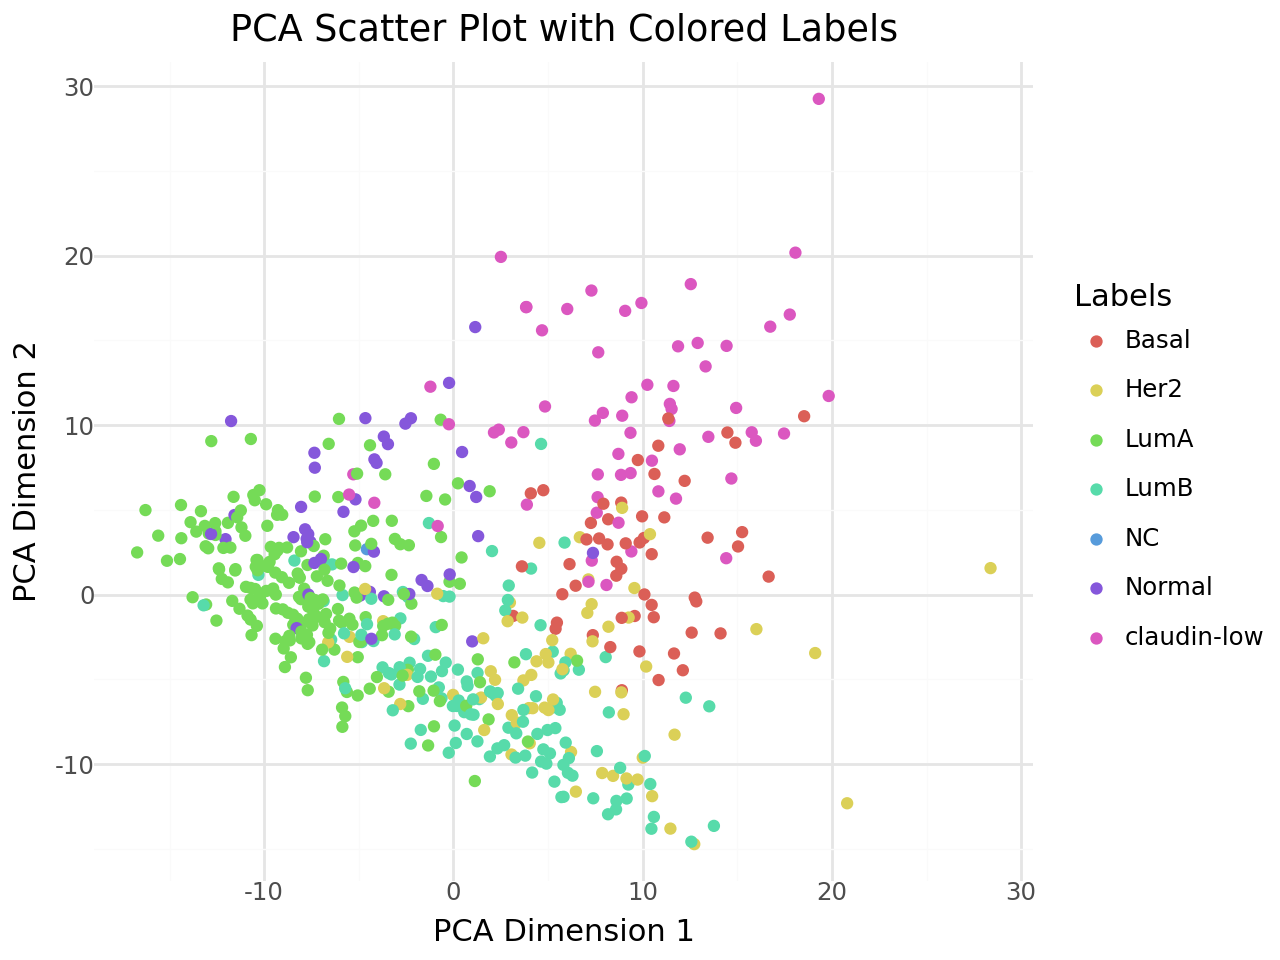

In [22]:
flexynesis.plot_dim_reduced(E, labels, color_type = 'categorical', method='pca')

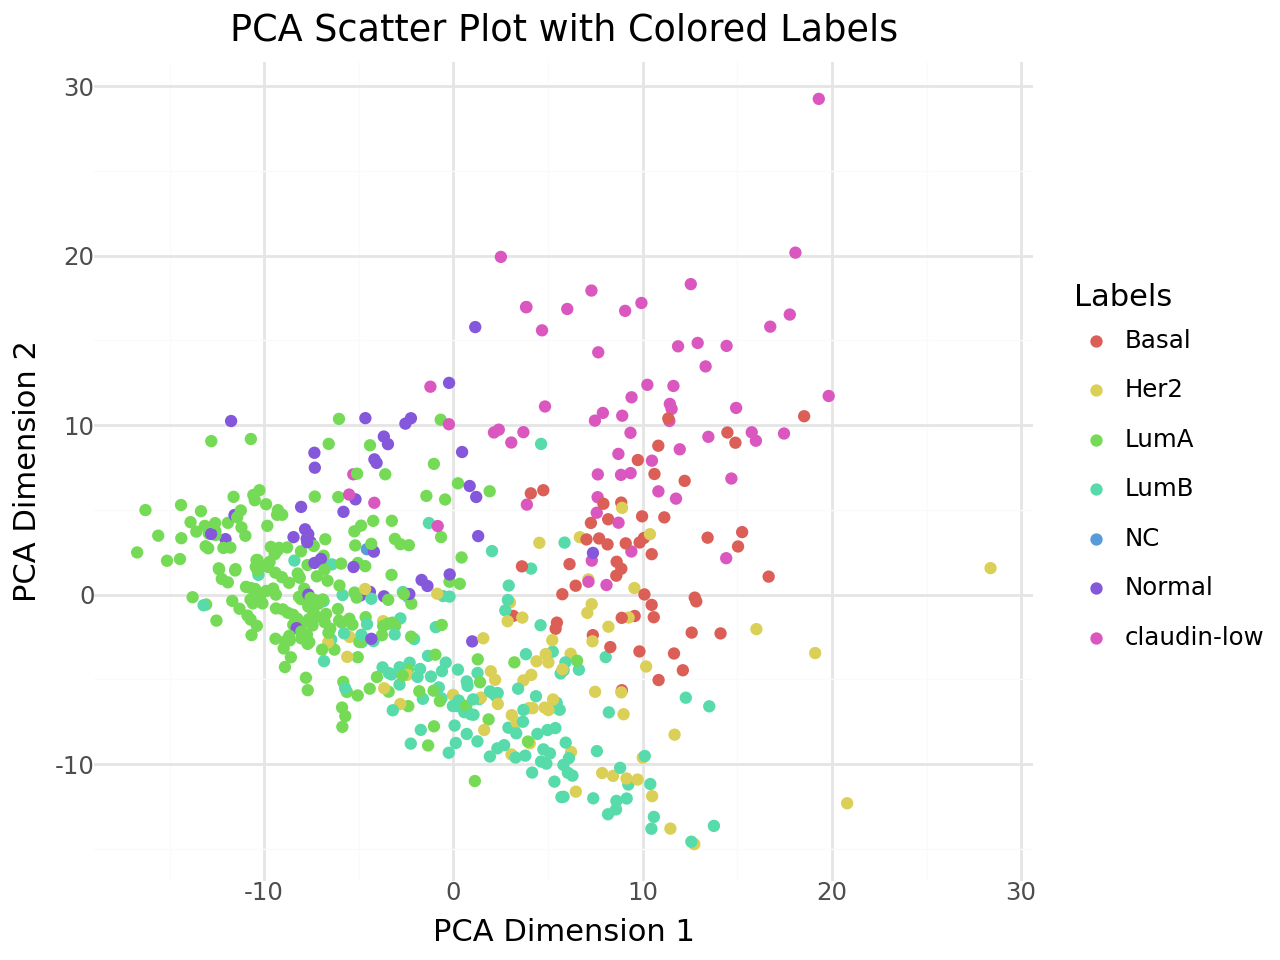

In [23]:
flexynesis.plot_dim_reduced(E, labels, color_type = 'categorical', method='pca')


We can also use UMAP visualisation

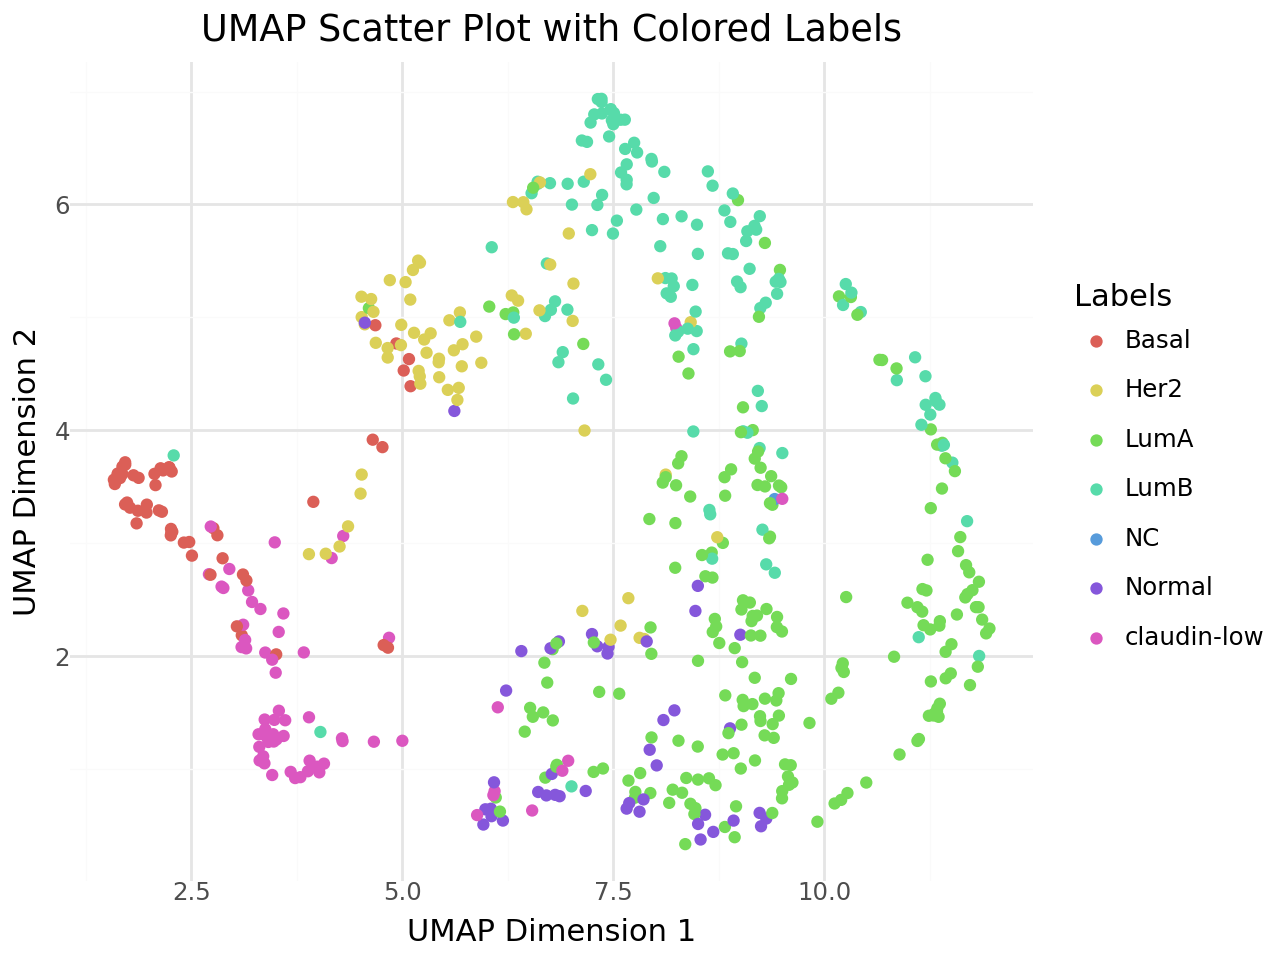

In [24]:
flexynesis.plot_dim_reduced(E, labels, color_type = 'categorical', method='umap')